### In QA V5, I check whether the length of T actually plays a role, or is it the same as adjusting alpha.

Here in QA V5.2, I only vary alpha.

# Conclusion

Between QA V5.1 and QA V5.2, the results turn out to be pretty much identical


Conclusion 1: from now on we can safely just set T_max to 1, and we only need to vary alpha, because increasing T_max and increasing alpha gives the same results. Why vary alpha instead of T_max? Because larger T_max makes the code longer to run, because now you have more time steps to iterate through, which means more matrix multiplications.


Conclusion 2: it seems that the accuracy-alpha graph is almost monotonically increasing. Which means if we want to increase the accuracy, we just need to increase alpha?

In [2]:
import numpy as np
from scipy.linalg import expm
import scipy
import matplotlib.pyplot as plt
import time

In [3]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

In [4]:
sigmaI = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
sigmaX = np.array(
    [
        [0, 1],
        [1, 0],
    ]
)
sigmaBin = np.array(
    [
        [0, 0],
        [0, 1],
    ]
)

In [5]:
Values = [10, 5]
Weights = [2, 3]
Ancil = [1, 2]

alpha = 1
beta = 1
gamma = max(Values) + 1
T = 1
dt = 0.01
t_axis = np.arange(0, T, dt)[0:]

In [6]:
H0 = np.array([
[ 0.,7.14,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 7.14,0.,10.097,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,10.097,0.,12.367,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,12.367,0.,14.28,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,14.28,0.,15.966,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,15.966,0.,17.489,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,17.489,0.,18.891,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,18.891,0.,20.195,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,20.195,0.,21.42,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,21.42,0.,22.579,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,22.579,0.,23.681,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,23.681,0.,24.734,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,24.734,0.,25.744,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,25.744,0.,26.715,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,26.715,0.,27.653],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,27.653,0.,]
])
# print(H0)

eigenvals_H0, eigenvecs_H0 = np.linalg.eigh(H0)
ground_idx_H0 = eigenvals_H0.argsort()[0]
print(eigenvals_H0[ground_idx_H0])
print(eigenvecs_H0[:, ground_idx_H0])

-47.34465334125993
[-0.     0.    -0.     0.001 -0.004  0.011 -0.026  0.056 -0.106  0.182
 -0.281  0.389 -0.475  0.5   -0.428  0.25 ]


In [7]:
Hp = (
    - (Values[0] * np.kron(np.kron(np.kron(sigmaBin, sigmaI), sigmaI), sigmaI) + Values[1] * np.kron(np.kron(np.kron(sigmaI, sigmaBin), sigmaI), sigmaI))
    + gamma * (
        (Weights[0] * np.kron(np.kron(np.kron(sigmaBin, sigmaI), sigmaI), sigmaI) + Weights[1] * np.kron(np.kron(np.kron(sigmaI, sigmaBin), sigmaI), sigmaI))
      - (Ancil[0] * np.kron(np.kron(np.kron(sigmaI, sigmaI), sigmaBin), sigmaI) + Ancil[1] * np.kron(np.kron(np.kron(sigmaI, sigmaI), sigmaI), sigmaBin))
    )**2
)
# print(Hp)

eigenvals_Hp, eigenvecs_Hp = np.linalg.eigh(Hp)
ground_idx_Hp = eigenvals_Hp.argsort()[0]
print(eigenvals_Hp[ground_idx_Hp])
print(eigenvecs_Hp[:, ground_idx_Hp])


-10.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [8]:
def H(t, T=1, alpha=1, beta=1):
    return alpha * ( (1 - t/T)*beta*H0 + (t/T)*Hp )

In [9]:
psi_ini = eigenvecs_H0[:, ground_idx_H0]
# print(psi_ini)
# print(np.linalg.norm(psi_ini))

psi_correct = eigenvecs_Hp[:, ground_idx_Hp]
# print(psi_correct)

In [10]:
# alpha = 0.1
alpha_list = np.arange(1e-1, 1e1, 1e-1)
accuracy_list = []

for alpha in alpha_list:
    start_time = time.time()

    junrui_unitary = np.identity(len(H0))
    for t in t_axis:
        junrui_unitary = expm(-1j * H(t, alpha=alpha) * dt) @ junrui_unitary

    psi_final = junrui_unitary @ psi_ini

    accuracy = np.abs( np.dot(psi_correct, psi_final) )**2
    accuracy_list.append(accuracy)

    end_time = time.time()
    # print(f"alpha = {alpha}, loop time: {end_time - start_time}")



In [11]:
print(accuracy_list)

[np.float64(0.05486248007671451), np.float64(0.23406244726533607), np.float64(0.42649701360294195), np.float64(0.36268169630384967), np.float64(0.22270347652306802), np.float64(0.17097235276908973), np.float64(0.2163991263434618), np.float64(0.3065965171676858), np.float64(0.383799595374222), np.float64(0.3887444538086738), np.float64(0.33775060326678685), np.float64(0.3473857626780653), np.float64(0.42724658605119553), np.float64(0.525415372470605), np.float64(0.5544723459335716), np.float64(0.5123335486057692), np.float64(0.4580241179421127), np.float64(0.45320825875746046), np.float64(0.5086832687749403), np.float64(0.5856139647490168), np.float64(0.6366725813860709), np.float64(0.636359906938771), np.float64(0.607037548451502), np.float64(0.5834820151793809), np.float64(0.5928945870299385), np.float64(0.6223966364334279), np.float64(0.6500427437621553), np.float64(0.668622499352099), np.float64(0.6879018367829972), np.float64(0.7056063960654808), np.float64(0.7129384782582702), np.

0.9853351195886103


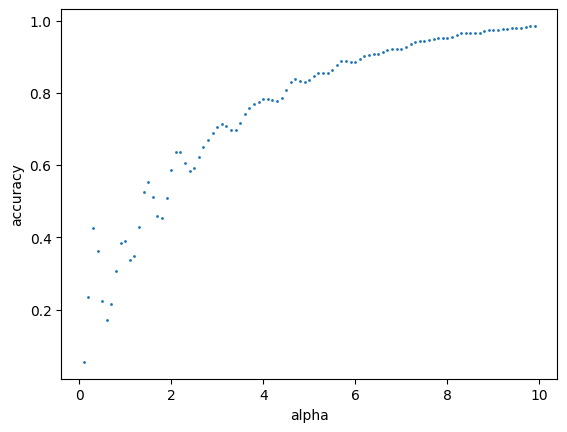

In [12]:
plt.scatter(alpha_list, accuracy_list, s=1)
plt.xlabel("alpha")
plt.ylabel("accuracy")
print(max(accuracy_list))

In [15]:
print(alpha_list[49])
print(accuracy_list[49])

5.0
0.8344712168975509
